# Sales funnel and A/A/B test analysis

Project description:

The goal is to investigate user behavior for a startup that sells food products.

The project involves studying the sales funnel and looking at the results of an A/A/B test.

The designers would like to change the fonts for the entire app, but the managers are afraid the users might find the new design intimidating. They decide to make a decision based on the results of an A/A/B test.

The users are split into three groups: two control groups get the old fonts and one test group gets the new ones. We need to find out which set of fonts produces better results.

## Preparing data for analysis

In [1]:
# loading the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
!pip install -U kaleido

In [2]:
# loading the dataset
df = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\t')

In [3]:
# looking at the genral info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Each log entry is a user action or an event

*  EventName — event name
*  DeviceIDHash — unique user identifier
*  EventTimestamp — event time
*  ExpId — experiment number: 246 and 247 are the control groups, 248 is the test group

In [4]:
# looking at the 1st 5 rows of the df
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
# renaming columns
df.rename(
    columns = {
        'EventName':'event_name',
        'DeviceIDHash':'Uid',
        'EventTimestamp':'event_time',
        'ExpId':'group'
    },
    inplace = True
)

In [6]:
# converting event_time to datetime data type
df['event_time'] = pd.to_datetime(df['event_time'], unit = 's')

In [7]:
df.head()

,event_name,Uid,event_time,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [8]:
# checking whether there are any missing values
df.isnull().sum()

event_name    0
Uid           0
event_time    0
group         0
dtype: int64

In [9]:
# looking at the unique events
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [10]:
# checking whether there are any duplicates
df.duplicated().sum()

413

In [11]:
# iterating over all columns and looking at duplicates - how many unique options there are
for i in df[df.duplicated()].columns:
    print(i, df[df.duplicated()][i].nunique())

event_name 5
Uid 237
event_time 352
group 3


It appears duplicates appear across all events, all groups, some users and also specific times.

In [12]:
# looking at the days duplicates show up
df[df.duplicated()]['event_time'].dt.date.unique()

array([datetime.date(2019, 7, 30), datetime.date(2019, 7, 31),
       datetime.date(2019, 8, 1), datetime.date(2019, 8, 2),
       datetime.date(2019, 8, 3), datetime.date(2019, 8, 4),
       datetime.date(2019, 8, 5), datetime.date(2019, 8, 6),
       datetime.date(2019, 8, 7)], dtype=object)

Duplicates have been recorded every day from July 30th until August 7th.

In [13]:
# creating a new df without the duplicates
df_new = df.drop_duplicates().reset_index(drop = True)

In [14]:
# adding date column to the df
df_new['date'] = df_new['event_time'].dt.date
df_new['date'] = pd.to_datetime(df_new['date'])

In [15]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   Uid         243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [16]:
df_new.head()

,event_name,Uid,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Studying and checking the data

In [17]:
# looking at how many unique users are there
df_new['Uid'].nunique()

7551

In [18]:
# looking at stastistics of events per user
df_new.groupby(['Uid'])['event_name'].count().reset_index()['event_name'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

On average there are 32 events per user. In 50% of cases 9 - 37 events.

In [19]:
# looking at unique events per user
df_new.groupby(['Uid'])['event_name'].nunique().reset_index()['event_name'].value_counts()

4    3035
1    2707
2    1021
5     471
3     317
Name: event_name, dtype: int64

It appears roughly half of users perform 4 events, but not all 5, that's rather rare.

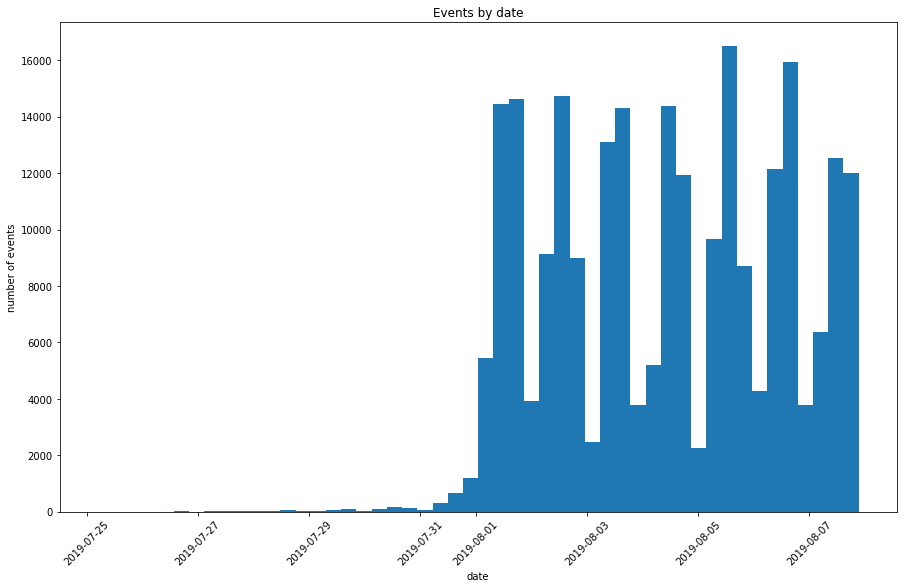

In [20]:
# plotting distribution of events
plt.figure(figsize=(15,9))
plt.hist(df_new['event_time'], bins=50)
plt.title('Events by date')
plt.xlabel('date')
plt.ylabel('number of events')
plt.xticks(rotation = 45)
plt.show()

It appears that older events have ended up in some users' logs, possibly due to technical reasons.

Data starts to appear complete only from August 1st.

Since the earlier data could skew the overall picture, we're going to exclude it from our analysis.

In [21]:
# filtering data that begins from Aug. 1st
df_week = df_new.query('event_time >= "2019-08-01"')

##  Studying the event funnel

In [22]:
# looking at how many unique users are there
df_week['Uid'].nunique()

7534

In [23]:
# looking at the frequency of events
df_week.groupby(['event_name'])['Uid'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: Uid, dtype: int64

In [24]:
# finding the number of users who performed each of the events
user_events = df_week.groupby(['event_name'])['Uid'].nunique().sort_values(ascending=False)
user_events

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: Uid, dtype: int64

In [25]:
# calculating the proportion of users who performed the action
user_ratio = df_week.groupby(['event_name'])['Uid'].nunique().sort_values(ascending=False) / df_week.Uid.nunique()
user_ratio.round(2)

event_name
MainScreenAppear           0.98
OffersScreenAppear         0.61
CartScreenAppear           0.50
PaymentScreenSuccessful    0.47
Tutorial                   0.11
Name: Uid, dtype: float64

98% of users viewed the main screen, 61% - offers screen, 50% were at the cart and 47% completed the payment. The tutorial was viewed only by 11% of users.

In [26]:
# sorting events of each user by time
event_seq = df_week.sort_values(by=['Uid','event_time'])

In [27]:
# checking random user
event_seq.query('Uid == 65731010663501604')

,event_name,Uid,event_time,group,date
87045,MainScreenAppear,65731010663501604,2019-08-03 11:07:32,248,2019-08-03
87050,Tutorial,65731010663501604,2019-08-03 11:07:34,248,2019-08-03
87059,Tutorial,65731010663501604,2019-08-03 11:07:48,248,2019-08-03
87066,MainScreenAppear,65731010663501604,2019-08-03 11:07:56,248,2019-08-03
87067,MainScreenAppear,65731010663501604,2019-08-03 11:07:57,248,2019-08-03
87079,MainScreenAppear,65731010663501604,2019-08-03 11:08:09,248,2019-08-03


The sequence of events that seems most apparent would be main screen --> offer --> cart --> payment. 

However, these events are not part of a single sequence.

Upon checking few random users, it appears that some of the actions can be done during anytime while using the app, like the tutorial. It also looks like the tutorial can be skipped and offers screen as well. In addition, it seems one could go straight to payment screen, not having to view the cart.

In [28]:
# finding the number of unique users who performed each of the events
event_funnel = df_week.groupby(['event_name'])['Uid'].nunique().sort_values(ascending=False).reset_index()
event_funnel.columns = ['event_name', 'no_of_users']
event_funnel.head(4)

,event_name,no_of_users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [29]:
# looking at the share of users that continued to the next stage
event_funnel['pct_change'] = event_funnel['no_of_users'].pct_change()
event_funnel.head(4)

,event_name,no_of_users,pct_change
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,-0.380914
2,CartScreenAppear,3734,-0.187024
3,PaymentScreenSuccessful,3539,-0.052223


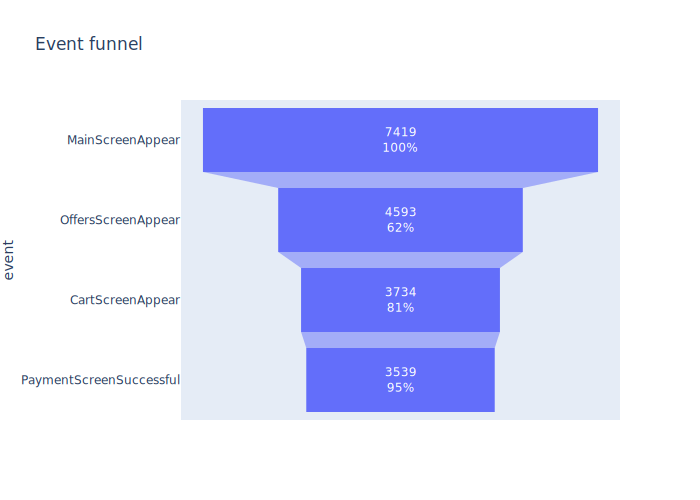

In [30]:
# plotting the event funnel
fig = go.Figure(go.Funnel(
     y = event_funnel['event_name'].head(4),
     x = event_funnel['no_of_users'].head(4),
     textinfo = "value+percent previous"))
fig.update_layout(
     title="Event funnel",
     yaxis_title="event",
     
 )
fig.show('svg')

From main screen to offers screen did not continue 38% of users. From offers screen to cart - 18% of users did not proceed to the next stage and from cart to payment only 5% did not proceed.

In [31]:
# looking at the funnel statistics by groups
group_funnel = []
for i in df_week.group.unique():
    group = df_week[df_week.group==i].groupby(['event_name','group'])['Uid'].nunique().reset_index().sort_values(by='Uid',ascending=False)
    group = group[group.event_name != 'Tutorial']
    display(group)
    group_funnel.append(group)

,event_name,group,Uid
1,MainScreenAppear,246,2450
2,OffersScreenAppear,246,1542
0,CartScreenAppear,246,1266
3,PaymentScreenSuccessful,246,1200


,event_name,group,Uid
1,MainScreenAppear,247,2476
2,OffersScreenAppear,247,1520
0,CartScreenAppear,247,1238
3,PaymentScreenSuccessful,247,1158


,event_name,group,Uid
1,MainScreenAppear,248,2493
2,OffersScreenAppear,248,1531
0,CartScreenAppear,248,1230
3,PaymentScreenSuccessful,248,1181


In [32]:
# combining the tables
group_funnel = pd.concat(group_funnel)

In [33]:
# renaming columns
group_funnel.columns = ['event_name', 'group', 'no_of_users']
group_funnel

,event_name,group,no_of_users
1,MainScreenAppear,246,2450
2,OffersScreenAppear,246,1542
0,CartScreenAppear,246,1266
3,PaymentScreenSuccessful,246,1200
1,MainScreenAppear,247,2476
2,OffersScreenAppear,247,1520
0,CartScreenAppear,247,1238
3,PaymentScreenSuccessful,247,1158
1,MainScreenAppear,248,2493
2,OffersScreenAppear,248,1531


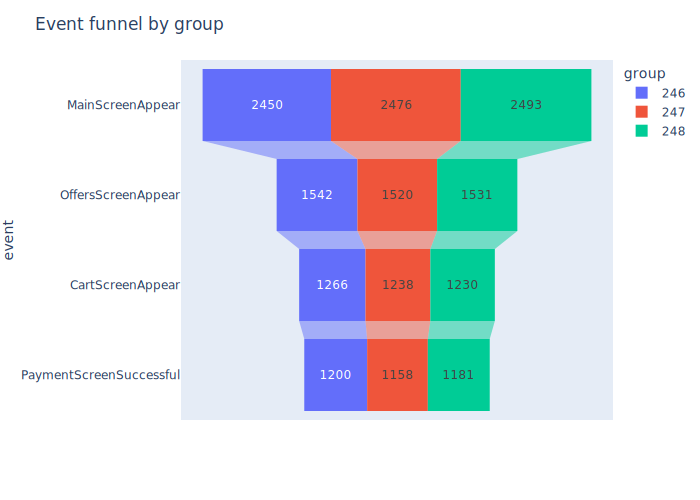

In [34]:
# plotting event funnel by groups
fig = px.funnel(group_funnel, x ='no_of_users',y='event_name',color='group')
fig.update_layout(
    title="Event funnel by group",
    yaxis_title="event",
    legend_title="group",
)
fig.show('svg')

It appears all 3 groups are very similar in their behaviour and in all 3 there is a big chunk of users who do not proceed further from the main screen. From offers to cart there's some loss too, but not as high.

However, it seems that conversion from cart to payment is quite successful.

Since tutorial is optional, it does not appear to be concerning that it's viewed by not that many users.

## Studying the results of the experiment

There are two control groups in the A/A test, where we will check our mechanisms and calculations. We need to see if there is a statistically significant difference between samples 246 and 247.

In [35]:
# checking whether any users belong to multiple groups
a = df_week.query('group == "246"')['Uid']
b = df_week.query('group == "247"')['Uid']
c = df_week.query('group == "248"')['Uid']
len((set(a) & set(b)) | (set(a) & set(c)) | (set(b) & set(c)))

0

In [36]:
# looking at how many users are in each group
df_week.groupby(['group'])['Uid'].nunique()

group
246    2484
247    2513
248    2537
Name: Uid, dtype: int64

In [37]:
# splitting amount of total unique users by groups
control_1 = df_week[df_week.group==246]['Uid'].nunique()
control_2 = df_week[df_week.group==247]['Uid'].nunique()
test = df_week[df_week.group==248]['Uid'].nunique()

In [38]:
control_1

2484

In [39]:
test

2537

In [40]:
# checking the difference between amount of users in group 246 and 247
100 - (control_1 / control_2 * 100)

1.1539992041384721

In [41]:
# finding the most popular event for group 246
events_246 = df_week[df_week.group==246].groupby('event_name').agg({'Uid':'nunique'}).sort_values(by='Uid', ascending=False)
events_246.head(1)

,Uid
event_name,
MainScreenAppear,2450


In [42]:
# finding the most popular event for group 247
events_247 = df_week[df_week.group==247].groupby('event_name').agg({'Uid':'nunique'}).sort_values(by='Uid', ascending=False)
events_247.head(1)

,Uid
event_name,
MainScreenAppear,2476


In [43]:
# looking at the share of the users from group 246 who entered main screen
events_246.head(1) / control_1

,Uid
event_name,
MainScreenAppear,0.986312


In [44]:
# looking at the share of the users from group 247 who entered main screen
events_247.head(1) / control_2

,Uid
event_name,
MainScreenAppear,0.985277


Most performed event for groups 246 and 247 is viewing the main screen.
From the 1st glance it appears there is not a significant difference between both control groups.

In [45]:
# creating a pivot table that shows amount of users who performed a targeted action
success_pivot = df_week.pivot_table(index='event_name', columns='group', values='Uid', aggfunc='nunique').reset_index()
success_pivot = success_pivot.sort_values(by=246, ascending=False).head(4)
# adding to the table the combined control group
success_pivot['246+247'] = success_pivot[246] + success_pivot[247]
success_pivot

group,event_name,246,247,248,246+247
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
0,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [46]:
# creating a df of unique users in each group 
trials = df_week.groupby('group')['Uid'].nunique().reset_index()
trials.loc[len(trials.index)] = ['246+247', df_week[df_week.group==246]['Uid'].nunique() + df_week[df_week.group==247]['Uid'].nunique()]
trials

,group,Uid
0,246,2484
1,247,2513
2,248,2537
3,246+247,4997


### Hypothesis testing

We will perform 16 tests together. To ensure we're not making false discoveries, we may use the Bonferroni correction, where we'll need to divide alpha of 0.05 with 16 - number of tests performed.

#### AA test

__246 and 247__

H0: there is no statistically significant difference in conversion funnel between group 246 and 247

H1: conversion funnel is statistically different between groups 246 and 247

In [47]:
# defining a function that will check whether the difference between the groups is statistically significant
def test_hypothesis(group1, group2, event, alpha):
    success1 = success_pivot[success_pivot.event_name==event][group1].iloc[0]
    success2 = success_pivot[success_pivot.event_name==event][group2].iloc[0]
    
    
    trials1 = trials[trials.group==group1]['Uid'].iloc[0]
    trials2 = trials[trials.group==group2]['Uid'].iloc[0]
    
   
    p_value = proportions_ztest([success1, success2], [trials1, trials2])[1]
    
    print(f'Proportion of {group1}: {success1/trials1:.5f}')
    print(f'Proportion of {group2}: {success2/trials2:.5f}')
    print(f'p-value: {p_value:.5f}')

    if (p_value < alpha):
        print("Rejecting the null hypothesis for", event,"and groups", group1, "and" ,group2)
    else:
        print("Failed to reject the null hypothesis for",event,"and groups", group1, "and", group2 )

In [48]:
0.05 / 16

0.003125

In [49]:
# checking the function
test_hypothesis('246+247',248,'MainScreenAppear',alpha=0.05 / 16)

Proportion of 246+247: 0.98579
Proportion of 248: 0.98266
p-value: 0.29425
Failed to reject the null hypothesis for MainScreenAppear and groups 246+247 and 248


In [50]:
# iterating over every event and performing the function
for i in success_pivot.event_name.unique():
    test_hypothesis(246, 247, i, alpha=0.05/16)
    print('-----------------------------')

Proportion of 246: 0.98631
Proportion of 247: 0.98528
p-value: 0.75706
Failed to reject the null hypothesis for MainScreenAppear and groups 246 and 247
-----------------------------
Proportion of 246: 0.62077
Proportion of 247: 0.60485
p-value: 0.24810
Failed to reject the null hypothesis for OffersScreenAppear and groups 246 and 247
-----------------------------
Proportion of 246: 0.50966
Proportion of 247: 0.49264
p-value: 0.22883
Failed to reject the null hypothesis for CartScreenAppear and groups 246 and 247
-----------------------------
Proportion of 246: 0.48309
Proportion of 247: 0.46080
p-value: 0.11457
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups 246 and 247
-----------------------------


For all of the events we are failing to reject the null hypothesis.
Group 246 and 247 are not statistically different in none of the events.

#### A/B test

__246 and 248__

H0: there is no statistically significant difference in conversion funnel between group 246 and 248

H1: conversion funnel is statistically different between groups 246 and 248

In [51]:
# iterating over every event and performing the function
for i in success_pivot.event_name.unique():
    test_hypothesis(246, 248, i, alpha=0.05/16)
    print('-----------------------------')

Proportion of 246: 0.98631
Proportion of 248: 0.98266
p-value: 0.29497
Failed to reject the null hypothesis for MainScreenAppear and groups 246 and 248
-----------------------------
Proportion of 246: 0.62077
Proportion of 248: 0.60347
p-value: 0.20836
Failed to reject the null hypothesis for OffersScreenAppear and groups 246 and 248
-----------------------------
Proportion of 246: 0.50966
Proportion of 248: 0.48482
p-value: 0.07843
Failed to reject the null hypothesis for CartScreenAppear and groups 246 and 248
-----------------------------
Proportion of 246: 0.48309
Proportion of 248: 0.46551
p-value: 0.21226
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups 246 and 248
-----------------------------


For all of the events we are failing to reject the null hypothesis. Group 246 and 248 are not statistically different in none of the events.

__247 and 248__

H0: there is no statistically significant difference in conversion funnel between group 247 and 248

H1: conversion funnel is statistically different between groups 247 and 248

In [52]:
# iterating over every event and performing the function
for i in success_pivot.event_name.unique():
    test_hypothesis(247, 248, i, alpha=0.05/16)
    print('-----------------------------')

Proportion of 247: 0.98528
Proportion of 248: 0.98266
p-value: 0.45871
Failed to reject the null hypothesis for MainScreenAppear and groups 247 and 248
-----------------------------
Proportion of 247: 0.60485
Proportion of 248: 0.60347
p-value: 0.91978
Failed to reject the null hypothesis for OffersScreenAppear and groups 247 and 248
-----------------------------
Proportion of 247: 0.49264
Proportion of 248: 0.48482
p-value: 0.57862
Failed to reject the null hypothesis for CartScreenAppear and groups 247 and 248
-----------------------------
Proportion of 247: 0.46080
Proportion of 248: 0.46551
p-value: 0.73734
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups 247 and 248
-----------------------------


For all of the events we are failing to reject the null hypothesis. Group 247 and 248 are not statistically different in none of the events.

__Combined control group (246 + 247) against test (248) group__

H0: there is no statistically significant difference in conversion funnel between group 246 and 247 combined against 248

H1: conversion funnel is statistically different between groups 246 and 247 combined against 248

In [53]:
# iterating over every event and performing the function
for i in success_pivot.event_name.unique():
    test_hypothesis('246+247', 248, i, alpha=0.05/16)
    print('-----------------------------')

Proportion of 246+247: 0.98579
Proportion of 248: 0.98266
p-value: 0.29425
Failed to reject the null hypothesis for MainScreenAppear and groups 246+247 and 248
-----------------------------
Proportion of 246+247: 0.61277
Proportion of 248: 0.60347
p-value: 0.43426
Failed to reject the null hypothesis for OffersScreenAppear and groups 246+247 and 248
-----------------------------
Proportion of 246+247: 0.50110
Proportion of 248: 0.48482
p-value: 0.18176
Failed to reject the null hypothesis for CartScreenAppear and groups 246+247 and 248
-----------------------------
Proportion of 246+247: 0.47188
Proportion of 248: 0.46551
p-value: 0.60043
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups 246+247 and 248
-----------------------------


For all of the events we are failing to reject the null hypothesis. Groups 246 and 247 combined and 248 are not statistically different in none of the events.

After conducting 16 tests, we haven't identified any significant differences among the groups, suggesting that altering the font is unlikely to have an impact on user behavior.

## General conclusion

__Funnel__

98% of all users viewed the main screen, 61% - offers screen, 50% were at the cart and 47% completed the payment. The tutorial was viewed only by 11% of all users.

From main screen to offers screen are lost biggest amount of users - 38%. From offers screen to cart - 18% of users did not proceed to the next stage and from cart to payment only 5% did not proceed. From payment screen to tutorial there were 76% of users who did not proceed.

When we look at all 3 groups separately, it appears all 3 groups are very similar in their behaviour and in all 3 there is a big chunk of users who do not proceed further from the main screen. From offers to cart there's some loss too, but not as high.

However, it seems that conversion from cart to payment is quite successful.

Since tutorial is optional, it does not appear to be concerning that it's viewed by few users.

__Test__

Based on the results of the A/A/B test, there were no differences between the control and test groups, suggesting that altering the font is unlikely to have an impact on user behavior.

__Recommendations__

Test could be conducted for few more weeks to make sure whether there are no difference in conversion indeed and change of fonts do not affect user behavior.

It might be worth investigating deeper why many of the users don't proceed further from the main screen. A fix in design or interface might improve user retention.